In [66]:
!pip install cantera

import matplotlib.pyplot as plt
import cantera as ct
import numpy as np

bilger_weights = {"C": 1.0, "H": 0.5, "O": -1}

def bilger_from_gas(gas, bilger_weights):

    b = 0.0

    for k, v in bilger_weights.items():
        if k in gas.element_names:
            Z_k = gas.elemental_mass_fraction(k)
            W_k = gas.atomic_weight(k)
        
            b += v * Z_k / W_k

    return b

def bilger_from_flame(flame, gas, bilger_weights):

    b = np.zeros_like(flame.grid)

    for k, v in bilger_weights.items():
        if k in gas.element_names:
            Z_k = flame.elemental_mass_fraction(k)
            W_k = gas.atomic_weight(k)
        
            b += v * Z_k / W_k

    return b

def phi_from_Z(Z, Z_stoichiometric):
    
    return Z * (1/Z_stoichiometric - 1) / (1 - Z)


In [67]:
# Define gas properties
T = 300.0 
p = ct.one_atm 
phi = 0.5
X_fuel = {"H2": 1.0} 
X_ox = {"O2": 1.0, "N2": 3.76}
mechanism = "h2o2.yaml"
width = 0.03 # m

# Calculate mixture fraction values at pure fuel and pure oxidizer conditions,
# and at stoichiometric conditions
gas_fuel = ct.Solution(mechanism)
gas_fuel.TPX = T, p, X_fuel
gas_ox = ct.Solution(mechanism)
gas_ox.TPX = T, p, X_ox
gas_st = ct.Solution(mechanism)
gas_st.TP = T, p
gas_st.set_equivalence_ratio(1.0, fuel=X_fuel, oxidizer=X_ox)

b_fuel = bilger_from_gas(gas_fuel, bilger_weights)
b_ox = bilger_from_gas(gas_ox, bilger_weights)
b_st = bilger_from_gas(gas_st, bilger_weights)
Z_st = (b_st - b_ox) / (b_fuel - b_ox)

In [68]:
transport_models = ["mixture-averaged", "unity-Lewis-number", "multicomponent"]
flames = {}
properties = {}

for transport_model in transport_models:
    gas = ct.Solution(mechanism)
    gas.TP = T, p
    gas.set_equivalence_ratio(phi, X_fuel, X_ox)

    flame = ct.FreeFlame(gas, width=width)
    flame.transport_model = transport_model
    flame.solve(loglevel=1)
    flames[transport_model] = flame

    b = bilger_from_flame(flame, gas, bilger_weights)
    Z = (b - b_ox) / (b_fuel - b_ox)
    phi_flame = phi_from_Z(Z, Z_st)

    properties[transport_model] = {}
    properties[transport_model]["Z"] = Z
    properties[transport_model]["phi"] = phi_flame


..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001139      4.772
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     3.421e-05       5.69
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.435e-05      6.355
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 2 3 4 
    to resolve H H2 H2O H2O2 HO2 N2 O O2 OH T velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem... 

Text(0.5, 1.0, '$\\phi = 0.5$')

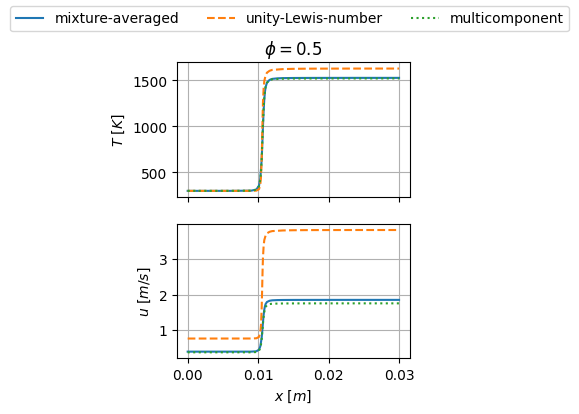

In [69]:
linestyles = {
    "mixture-averaged": "-",
    "unity-Lewis-number": "--",
    "multicomponent": ":"
}

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(3, 4), sharex=True)

for transport_model, flame in flames.items():
    ax = axs[0]
    ax.plot(flame.grid, flame.T, label=transport_model, linestyle=linestyles[transport_model])

    ax = axs[1]
    ax.plot(flame.grid, flame.velocity, linestyle=linestyles[transport_model])

axs[0].set(ylabel=r"$T$ $[K]$")
axs[1].set(xlabel=r"$x$ $[m]$", ylabel=r"$u$ $[m/s]$")

axs[0].grid()
axs[1].grid()

# Fig.legend on top
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)
fig.subplots_adjust(top=0.85)
axs[0].set_title(r"$\phi = {}$" .format(phi))

plt.show()

Text(0.5, 1.0, '$\\phi = 0.5$')

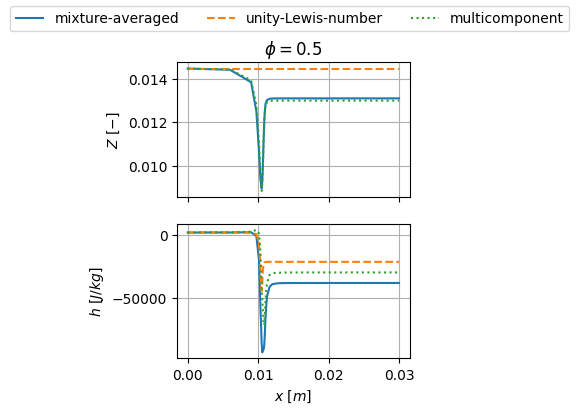

In [74]:
# Plot mixture fraction and enthalpy
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(3, 4), sharex=True)

for transport_model, flame in flames.items():
    ax = axs[0]
    ax.plot(flame.grid, properties[transport_model]["Z"], label=transport_model, linestyle=linestyles[transport_model])

    ax = axs[1]
    ax.plot(flame.grid, flame.enthalpy_mass, linestyle=linestyles[transport_model])

axs[0].set(ylabel=r"$Z$ $[-]$")
axs[1].set(xlabel=r"$x$ $[m]$", ylabel=r"$h$ $[J/kg]$")
axs[0].grid()
axs[1].grid()

# Fig.legend on top
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)
fig.subplots_adjust(top=0.85)
axs[0].set_title(r"$\phi = {}$" .format(phi))
